In [1]:
# System libraries
import time
import io
import itertools

# Custom libraries
import dl_utils as utils
import load_mnist as mnist

# Helper libraries
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [86]:
train, _, test = mnist.read_mnist('mnist/',flatten=True)

class LogisticRegression:
    
    
    def __init__(self, log='False'):
        self.batch_size = 128
        ## Hyperparameters Setup ## 
        #self.epochs = 10
        self.lr = 0.001
        self.logdir = './graphs/logistic'
        self.log = log
        tf.reset_default_graph()
        
    def set_session(self,session_type='cpu'):
        '''
        Set a new tf session cpu/gpu
        '''
        if session_type == 'cpu':
            self.sess = tf.Session()
        else:
            self.sess = utils.gpu_session()
            print("GPU session loaded...")
            
    
    def get_data(self):
        
        #train, _, test = mnist.read_mnist('mnist/',flatten=True)
        with tf.name_scope('data'):

            # Define tf.Data and Iterators
            train_data = tf.data.Dataset.from_tensor_slices(train)
            test_data = tf.data.Dataset.from_tensor_slices(test)

            train_data = train_data.batch(self.batch_size,drop_remainder=False)
            test_data = test_data.batch(self.batch_size,drop_remainder=True)

            iterator = tf.data.Iterator.from_structure(train_data.output_types,
                                                       train_data.output_shapes)


            self.img, self.label = iterator.get_next()

            self.train_init = iterator.make_initializer(train_data)	# initializer for train_data
            self.test_init  = iterator.make_initializer(test_data)	# initializer for test_data
            
            ## Create weight in shape of mnist dataset and bias initialised to 0
            self.w = tf.get_variable(name='weights', shape=(784, 10), initializer=tf.random_normal_initializer(0, 0.01))
            self.b = tf.get_variable(name='bias', shape=(1, 10), initializer=tf.zeros_initializer())

    def loss(self):
        '''
        Define Loss function
        '''
        ## 
        self.logits = tf.matmul(self.img,self.w) + self.b    
        
        ## Define Loss function for logistic regression
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.label, logits=self.logits,name='loss')
        
        ## Computes the mean over all the examples in the batch
        self.loss = tf.reduce_mean(loss, name='loss')

    def predict(self):
        '''
        Define prediction and accuracy
        '''        
        ## Build Model - Define Preds ##
        self.y_hat = tf.nn.softmax(self.logits)
        correct_preds = tf.equal(tf.argmax(self.y_hat, 1), tf.argmax(self.label, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
        
    def optimizer(self):
        '''
        Define gradient descent as the optimizer to minimise the loss
        '''
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss)

    def logistic_model(self, epochs):
        '''
        Train and evaluate model
        :param epochs: number of epochs
        '''
        #with tf.Session() as sess:
        self.sess.run(tf.global_variables_initializer())

        # Start training
        for epoch in range(epochs):

            self.sess.run(self.train_init)
            total_loss = 0
            local_batch = 0
            batch_acc = 0
            train_acc = 0
            mean_acc = 0
            n_batches = 0
            try:
                while True:
                    _, batch_loss, batch_acc = self.sess.run([self.optimizer, self.loss,self.accuracy])
                    #batch_acc = self.sess.run(self.accuracy)
                    total_loss += batch_loss
                    local_batch += 1
                    train_acc += batch_acc
                    n_batches += self.batch_size
            except tf.errors.OutOfRangeError:
                pass
            
            if epoch % 10 == 0: #and epoch != 0:
                print('Epoch %d - Train loss: %.4f - Train Accuracy: %.4f' % (epoch, total_loss/local_batch, train_acc/n_batches * 100))

        # Test the model
        self.sess.run(self.test_init) # drawing samples from test_data
        sum_preds = []
        test_accuracy = 0
        test_loss = 0
        try:
            while True:
                batch_preds, batch_loss, batch_accuracy = self.sess.run([self.y_hat, self.loss, self.accuracy])
                test_loss += batch_loss
                test_accuracy += batch_accuracy
                sum_preds.append(batch_preds)
                n_batches += self.batch_size
                
        except tf.errors.OutOfRangeError:
            pass
        print("Test Loss %.3f" % (test_accuracy/local_batch))
        print("Test Accuracy %.3f" % (test_accuracy))

        if self.log:
            writer = tf.summary.FileWriter(self.logdir) # self.sess.graph()

            self.log_confusion_matrix(sum_preds)

            # Merge with the other summaries
            merged = tf.summary.merge_all()
            summary = self.sess.run(merged)
            writer.add_summary(summary)
            writer.close()
            
        #if self.verbose:
        #    self.plot_predictions(sum_preds)
        
        return sum_preds


    def plot_confusion_matrix(self, cm, class_names):
        '''
        Returns a matplotlib figure containing the plotted confusion matrix.
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
        '''
        figure = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        # Normalize the confusion matrix.
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        return figure

    def plot_to_image(self,figure):
        '''
        Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call.
        '''
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)

        return image   
    
    def log_confusion_matrix(self,sum_preds):
        '''
        
        '''
        # Use the model to predict the values from the validation dataset.
        predictions = np.argmax(np.concatenate(sum_preds),axis=1)

        # Calculate the confusion matrix.
        cm = confusion_matrix(np.argmax(test[1][:len(predictions)],axis=1), predictions)
        
        # Convert image to tensor
        cm_image = self.plot_to_image(self.plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7,8,9]))

        # Log the confusion matrix as an image summary.
        tf.summary.image("Confusion_Matrix", cm_image,max_outputs=1)

    def plot_predictions(self, predictions):
        '''
        Make a subplot of random test images-predicted label
        '''
        # Choose 10 random images to infere
        rnd_inference = np.random.randint(0,10000,10)
        predicted_classes = np.argmax(np.concatenate(predictions),axis=1)

        # Plot images with their predicted labels
        plt.figure(figsize=(28,28))
        for idx,image in enumerate(rnd_inference):
            plt.subplot(10,1,1+idx)
            plt.title("Predicted Number: "+ str(predicted_classes[image]))
            fig = plt.imshow(np.reshape(test[0][image],(28,28)), cmap='gray')
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)    
            
    def build_graph(self):
        '''
        Build computational graph
        '''
        self.get_data()
        self.loss()
        self.optimizer()
        self.predict()

In [87]:
lr = LogisticRegression(log=False)

In [88]:
lr.build_graph()
lr.set_session('gpu')

GPU session loaded...


In [89]:
preds = lr.logistic_model(71)

Epoch 0 - Train loss: 2.0978 - Train Accuracy: 0.4164
Epoch 10 - Train loss: 0.8351 - Train Accuracy: 0.6539
Epoch 20 - Train loss: 0.6388 - Train Accuracy: 0.6704
Epoch 30 - Train loss: 0.5570 - Train Accuracy: 0.6777
Epoch 40 - Train loss: 0.5103 - Train Accuracy: 0.6825
Epoch 50 - Train loss: 0.4795 - Train Accuracy: 0.6869
Epoch 60 - Train loss: 0.4572 - Train Accuracy: 0.6894
Epoch 70 - Train loss: 0.4402 - Train Accuracy: 0.6919
Test Loss 0.162
Test Accuracy 69.695


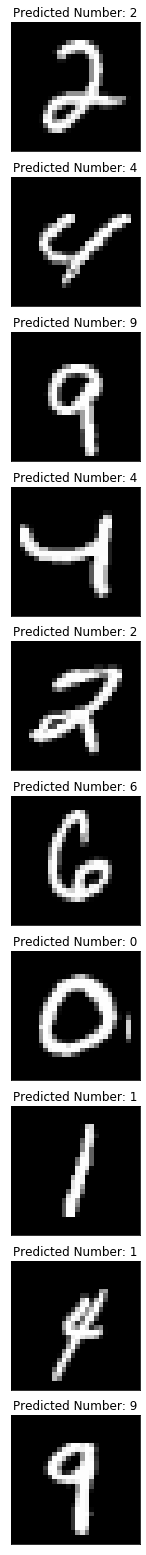

In [90]:
lr.plot_predictions(preds)

In [91]:
%load_ext tensorboard
%tensorboard --logdir graphs/logistic/ --port 1111